In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import glob
import os
import yaml
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


# Varying sigma models

In [2]:
from postprocessing import report_model

records = []
for path in glob.glob('models/vary_sigma/*'):
    if not os.path.isdir(path): continue
    record = report_model(path)
    if record is not None:
        records.append(record)

for path in glob.glob('models/fixed_sigma/*'):
    if not os.path.isdir(path): continue
    record = report_model(path)
    if record is not None and record['objective'] == 'Relative density' and record['housing']:
        records.append(record)

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values(by=['objective', 'sigma', 'rel_val_err']).drop(columns='path').set_index(['objective', 'sigma', 'id'])

val_err  rel_val_err  val_loss  train_loss  \
objective        sigma id                                                       
Relative density 2     4137625_0  0.010132     0.639796  0.058512    0.000310   
                       4137633_0  0.010909     0.656615  0.059460    0.000329   
                       4137618_0  0.012786     0.734535  0.064556    0.000357   
                 3     3761106_5  0.008319     0.555950  0.059136    0.000312   
                       3701409_5  0.008196     0.569870  0.062450    0.000328   
                       4137633_1  0.007954     0.576406  0.061861    0.000318   
                       4137618_1  0.007204     0.576577  0.061240    0.000294   
                       4137625_1  0.009426     0.703058  0.072718    0.000435   
                       3761096_5  0.013818     0.848212  0.082111    0.000564   
                 4     4137625_2  0.005859     0.555802  0.064615    0.000330   
                       4137618_2  0.007878     0.722045  0.079234    0.000478   
                       4137633_2  0.007914     0.817446  0.091072    0.000453   
                 5     4137633_3  0.004391     0.496626  0.059253    0.000310   
                       4137625_3  0.004704     0.545656  0.065320    0.000295   
                       4137618_3  0.005788     0.644694  0.076019    0.000317   

                                  val_tmax  num_train_counties  housing  
objective        sigma id                                                
Relative density 2     4137625_0        10                  31     True  
                       4137633_0        10                  31     True  
                       4137618_0        10                  31     True  
                 3     3761106_5        10                  31     True  
                       3701409_5        10                  31     True  
                       4137633_1        10                  31     True  
                       4137618_1        10                  31     True  
                       4137625_1        10                  31     True  
                       3761096_5        10                  31     True  
                 4     4137625_2        10                  31     True  
                       4137618_2        10                  31     True  
                       4137633_2        10                  31     True  
                 5     4137633_3        10                  31     True  
                       4137625_3        10                  31     True  
                       4137618_3        10                  31     True

## $\sigma = 2$

4137625_0
<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342) 2.933925610035658 -6.093370690941811
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144) 3.354698784649372 -5.44601633399725
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150) 3.37312051653862 -5.965650372207165
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235) 2.947465144097805 -6.280241072177887
170.5 169.0


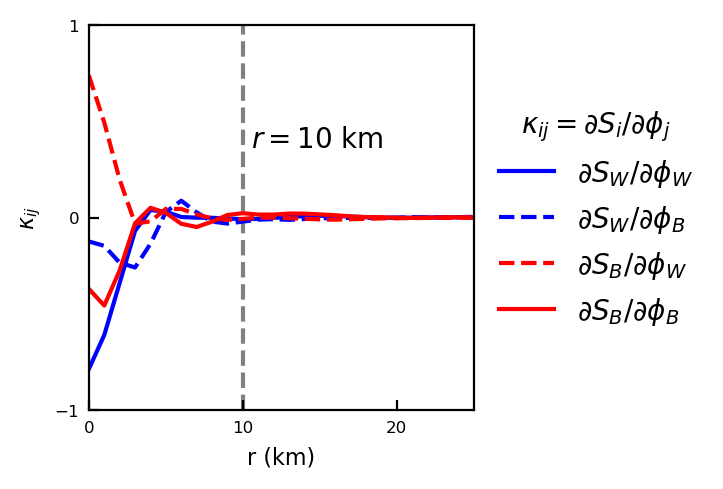

In [9]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

sub_df = df[df.sigma == 2].reset_index(drop=True)
model_id = sub_df.loc[sub_df.rel_val_err.argmin(), 'id']
print(model_id)

if model_id in os.listdir('models/fixed_sigma'):
    path = f'models/fixed_sigma/{model_id}'
elif model_id in os.listdir('models/vary_sigma'):
    path = f'models/vary_sigma/{model_id}'

with h5py.File(f'{path}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape, np.max(G_s[-1]), np.min(G_s[-1]))

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa_{ij}$')
ax.set(
    xlim=[0, 25],
    ylim=[-1, 1],
    xticks=[0, 10, 20],
    yticks=[-1, 0, 1]
)
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 10
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5], title='$\\kappa_{ij} = \\partial S_i / \\partial \\phi_j$')

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)
170.5 169.0


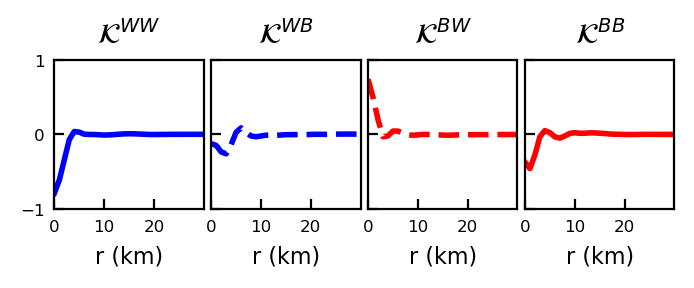

In [10]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

with h5py.File(f'{path}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 4, figsize=(4, 1), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    r'$\mathcal{K}^{WW}$',
    r'$\mathcal{K}^{WB}$',
    r'$\mathcal{K}^{BW}$',
    r'$\mathcal{K}^{BB}$',
]

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax[i].plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=2)
    ax[i].set_xlabel('r (km)')

    ax[i].set(
        xlim=[0, 30],
        ylim=[-1, 1],
        xticks=[0, 10, 20],
        yticks=[-1, 0, 1]
    )
    ax[i].set_aspect(np.ptp(ax[i].get_xlim()) / np.ptp(ax[i].get_ylim()))
    ax[i].tick_params(which='both', direction='in')
    ax[i].set_title(labels[i])

fig.subplots_adjust(wspace=0.05)


## $\sigma = 3 $

3761106_5
<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342) 6.493155684322119 -10.940459571778774
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144) 5.788603035733104 -10.517342548351735
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150) 6.363399771973491 -13.078369922935963
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235) 6.583591196686029 -11.97804152034223
170.5 169.0


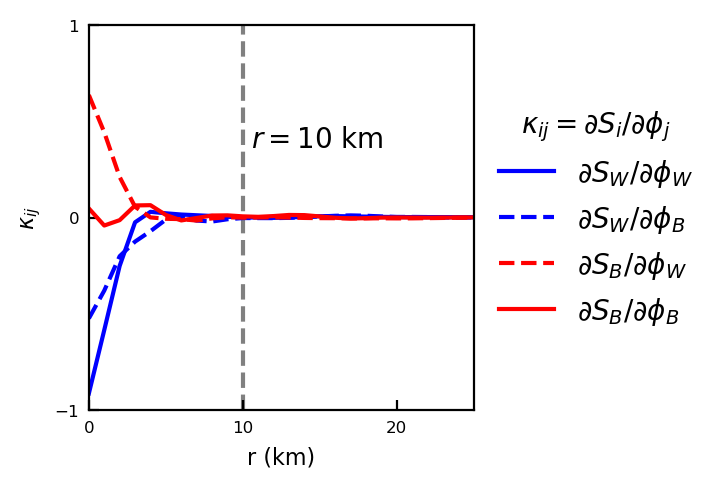

In [11]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

sub_df = df[df.sigma == 3].reset_index(drop=True)
model_id = sub_df.loc[sub_df.rel_val_err.argmin(), 'id']
print(model_id)

if model_id in os.listdir('models/fixed_sigma'):
    path = f'models/fixed_sigma/{model_id}'
elif model_id in os.listdir('models/vary_sigma'):
    path = f'models/vary_sigma/{model_id}'

with h5py.File(f'{path}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape, np.max(G_s[-1]), np.min(G_s[-1]))

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa_{ij}$')
ax.set(
    xlim=[0, 25],
    ylim=[-1, 1],
    xticks=[0, 10, 20],
    yticks=[-1, 0, 1]
)
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 10
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5], title='$\\kappa_{ij} = \\partial S_i / \\partial \\phi_j$')

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)
170.5 169.0


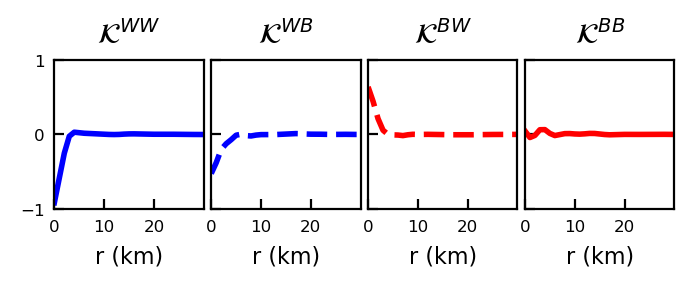

In [12]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

with h5py.File(f'{path}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 4, figsize=(4, 1), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    r'$\mathcal{K}^{WW}$',
    r'$\mathcal{K}^{WB}$',
    r'$\mathcal{K}^{BW}$',
    r'$\mathcal{K}^{BB}$',
]

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax[i].plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=2)
    ax[i].set_xlabel('r (km)')

    ax[i].set(
        xlim=[0, 30],
        ylim=[-1, 1],
        xticks=[0, 10, 20],
        yticks=[-1, 0, 1]
    )
    ax[i].set_aspect(np.ptp(ax[i].get_xlim()) / np.ptp(ax[i].get_ylim()))
    ax[i].tick_params(which='both', direction='in')
    ax[i].set_title(labels[i])

fig.subplots_adjust(wspace=0.05)


## $\sigma = 4 $

4137625_2
<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342) 8.90639778971672 -15.50292158126831
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144) 7.793820023536682 -13.531486630439758
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150) 9.072182148694992 -15.11921700835228
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235) 9.286056756973267 -15.687496423721313
170.5 169.0


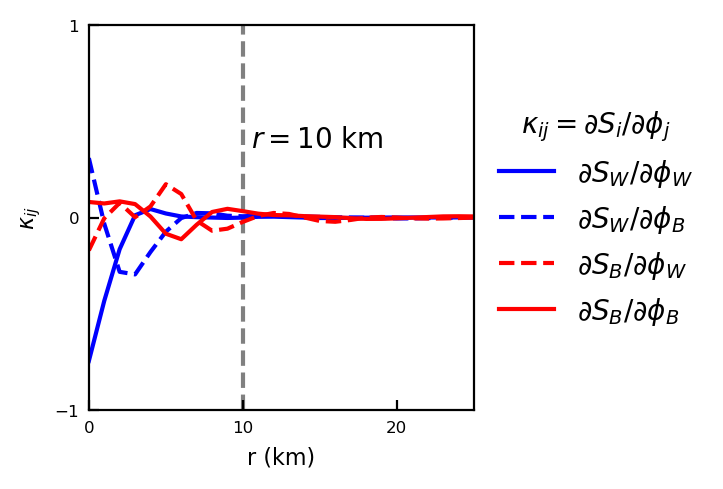

In [13]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

sub_df = df[df.sigma == 4].reset_index(drop=True)
model_id = sub_df.loc[sub_df.rel_val_err.argmin(), 'id']
print(model_id)

if model_id in os.listdir('models/fixed_sigma'):
    path = f'models/fixed_sigma/{model_id}'
elif model_id in os.listdir('models/vary_sigma'):
    path = f'models/vary_sigma/{model_id}'

with h5py.File(f'{path}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape, np.max(G_s[-1]), np.min(G_s[-1]))

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa_{ij}$')
ax.set(
    xlim=[0, 25],
    ylim=[-1, 1],
    xticks=[0, 10, 20],
    yticks=[-1, 0, 1]
)
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 10
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5], title='$\\kappa_{ij} = \\partial S_i / \\partial \\phi_j$')

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)
170.5 169.0


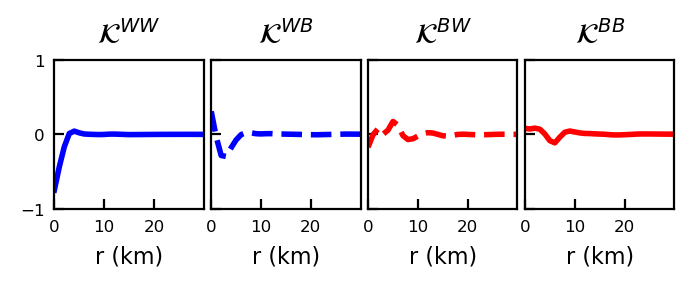

In [14]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

with h5py.File(f'{path}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 4, figsize=(4, 1), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    r'$\mathcal{K}^{WW}$',
    r'$\mathcal{K}^{WB}$',
    r'$\mathcal{K}^{BW}$',
    r'$\mathcal{K}^{BB}$',
]

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax[i].plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=2)
    ax[i].set_xlabel('r (km)')

    ax[i].set(
        xlim=[0, 30],
        ylim=[-1, 1],
        xticks=[0, 10, 20],
        yticks=[-1, 0, 1]
    )
    ax[i].set_aspect(np.ptp(ax[i].get_xlim()) / np.ptp(ax[i].get_ylim()))
    ax[i].tick_params(which='both', direction='in')
    ax[i].set_title(labels[i])

fig.subplots_adjust(wspace=0.05)


## $\sigma = 5$

4137633_3
<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342) 8.70772548019886 -7.962153121829033
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144) 7.6287194192409515 -6.903691783547401
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150) 8.467572033405304 -8.518768444657326
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235) 8.875557199120522 -8.41064040362835
170.5 169.0


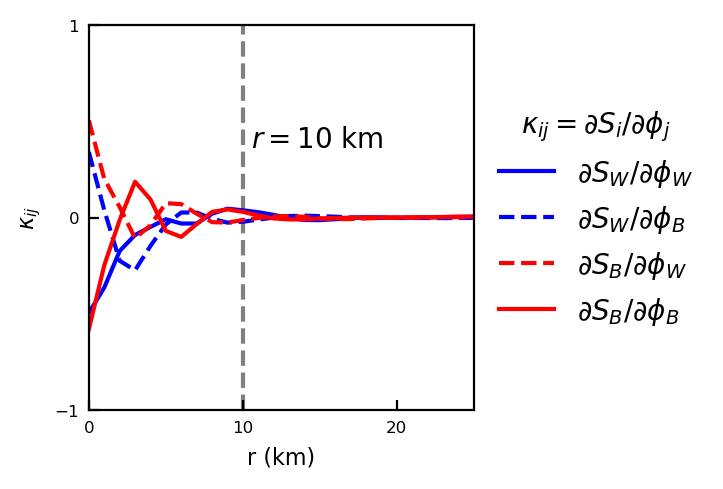

In [15]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

sub_df = df[df.sigma == 5].reset_index(drop=True)
model_id = sub_df.loc[sub_df.rel_val_err.argmin(), 'id']
print(model_id)

if model_id in os.listdir('models/fixed_sigma'):
    path = f'models/fixed_sigma/{model_id}'
elif model_id in os.listdir('models/vary_sigma'):
    path = f'models/vary_sigma/{model_id}'

with h5py.File(f'{path}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape, np.max(G_s[-1]), np.min(G_s[-1]))

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa_{ij}$')
ax.set(
    xlim=[0, 25],
    ylim=[-1, 1],
    xticks=[0, 10, 20],
    yticks=[-1, 0, 1]
)
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 10
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5], title='$\\kappa_{ij} = \\partial S_i / \\partial \\phi_j$')

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)
170.5 169.0


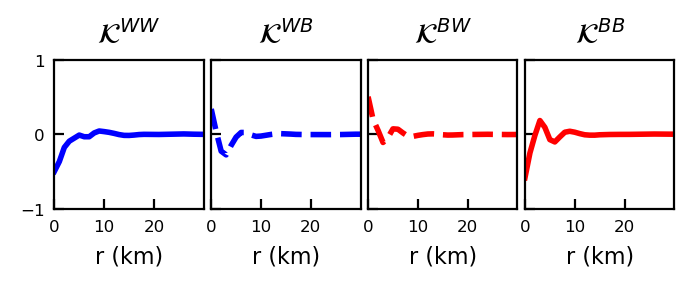

In [16]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

with h5py.File(f'{path}/aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 4, figsize=(4, 1), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    r'$\mathcal{K}^{WW}$',
    r'$\mathcal{K}^{WB}$',
    r'$\mathcal{K}^{BW}$',
    r'$\mathcal{K}^{BB}$',
]

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax[i].plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=2)
    ax[i].set_xlabel('r (km)')

    ax[i].set(
        xlim=[0, 30],
        ylim=[-1, 1],
        xticks=[0, 10, 20],
        yticks=[-1, 0, 1]
    )
    ax[i].set_aspect(np.ptp(ax[i].get_xlim()) / np.ptp(ax[i].get_ylim()))
    ax[i].tick_params(which='both', direction='in')
    ax[i].set_title(labels[i])

fig.subplots_adjust(wspace=0.05)
